In [104]:
import hopsy
import numpy as np
import arviz as az

import x3c2fluxpy as x3c
#import x3cflux2adapter as _x3c

import time

from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

import warnings
from multiprocessing import Pool

import dill
from tqdm.notebook import tqdm

import corner

session = "bruteforce"

figsize = np.array([6.4, 4.8])

In [12]:
dims = [2]#, 5, 10, 20]#, 30, 50]

n_parallel = 50
n_seeds = 5
n_chains = 10

n_samples = 10_000
n_samples_order = 1

ts_params = {
    "lower_bound": 1e-2,
    "upper_bound": 1e3,
    "grid_size": 51,
    #"lower_bound": 1e-1,
    #"upper_bound": 1e1,
    #"grid_size": 41,
    "record_data": True,
    "n_convergence": 20,
}

#stepsize_grid = 10**(np.linspace(np.log10(ts_params["lower_bound"]), np.log10(ts_params["upper_bound"]), ts_params["grid_size"])) # log-uniformly distributed stepsizes

stepsize_grid = 10**np.array(np.hstack([np.linspace(-5, -2, 15)[:-1], np.linspace(-2, 0, 41)[:-1], np.linspace(0, 3, 15)]))
print(stepsize_grid)

#targets = {
#    "Acceptance\nRate\n(1-norm)": lambda mcs, dim: hopsy.AcceptanceRateTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order),
#    "Acceptance\nRate\n(2-norm)": lambda mcs, dim: hopsy.AcceptanceRateTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order, order=2),
#    "ESJD": lambda mcs, dim: hopsy.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order),
#    "1,5-ESJD": lambda mcs, dim: hopsy.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order, lags=[1, 5]),
#    "ESJD/s": lambda mcs, dim: hopsy.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order, consider_time_cost=True),
#    "1,5-ESJD/s": lambda mcs, dim: hopsy.ExpectedSquaredJumpDistanceTarget(mcs, n_test_samples=n_test_samples*dim**n_samples_order, consider_time_cost=True, lags=[1, 5]),
#}

problems = {
    #"Truncated Gaussian": [(dim, hopsy.add_box_constraints(
    #    hopsy.Problem(-np.identity(dim), [0]*dim, hopsy.Gaussian(mean=np.zeros(dim)), starting_point=1e-5*np.ones(dim)), 0, 100), "") for dim in dims],
    "STAT-1": [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "STAT-1") for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal.fml")]], #+
    "STAT-1-ni": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model, model.initial_point), -1000, 1000), "STAT-1-ni") 
                  for model in [x3c.X3CModel("models/Spiralus_STAT_unimodal_ni.fml")]], #+
    "STAT-2": [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "STAT-2") for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal.fml")]], #+
    "STAT-2-ni": [(model.A.shape[1], hopsy.add_box_constraints(hopsy.Problem(model.A, model.b, model, model.initial_point), -1000, 1000), "STAT-2-ni") 
                  for model in [x3c.X3CModel("models/Spiralus_STAT_bimodal_ni.fml")]], #+
    #            [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "Stationary (base)") for model in [x3c.X3CModel("models/Spiralus_STAT_base_FJ.fml", "ms+uptake")]] + 
    #            [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "Stationary (perturbed)") for model in [x3c.X3CModel("models/Spiralus_STAT_perturbed_FJ.fml", "ms+uptake")]] + 
    #            [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "Instationary (base)") for model in [x3c.X3CModel("models/Spiralus_INST_base_FJ.fml", "ms+ps+uptake")]],
    #"E.Coli": [(model.A.shape[1], hopsy.Problem(model.A, model.b, model, model.initial_point), "Crown, Stationary, std=0.004 (perturbed)") 
    #                                     for model in [x3c.X3CModel("models/Crown_Ecoli_STAT_0.004_perturbed.fml", "resolve_tca")]],
}

for key, problem in problems.items():
    print(key, problem[0][1].A.shape[-1])

proposals = {
#    "Adaptive Metropolis": hopsy.AdaptiveMetropolisProposal,
    "BallWalk": hopsy.BallWalkProposal,
    "CSmMALA": hopsy.CSmMALAProposal,
    "DikinWalk": hopsy.DikinWalkProposal,
    "Gaussian": hopsy.GaussianProposal,
    "Gaussian Hit-And-Run": hopsy.GaussianHitAndRunProposal,
}

targets = {
    r"min $n_{\mathrm{eff}}$": (lambda rhat, elapsed, accrate, states: [np.min(hopsy.ess(states))]*n_chains),
    r"min $n_{\mathrm{eff}}$/t": (lambda rhat, elapsed, accrate, states: [np.min(hopsy.ess(states)) / (elapsed / states.shape[1])]*n_chains),
    r"max $\hat{R}$": (lambda rhat, elapsed, accrate, states: [rhat]*n_chains),
    "Acceptance Rate": (lambda rhat, elapsed, accrate, states: np.mean(accrate, axis=0)),
    "ESJD": (lambda rhat, elapsed, accrate, states: np.mean(np.linalg.norm(np.diff(states, axis=1), axis=-1)**2, axis=-1)),
    "ESJD/t": (lambda rhat, elapsed, accrate, states: np.mean(np.linalg.norm(np.diff(states, axis=1), axis=-1)**2, axis=-1) / (elapsed / states.shape[1])),
    "T/n": (lambda rhat, elapsed, accrate, states: [elapsed / states.shape[1]]*n_chains),
}

rhat_threshold=1.05
n_max = 20

def f(Proposal, problem, dim, stepsize, seed):
    mcs = [hopsy.MarkovChain(problem, Proposal) for i in range(n_chains)]
    for mc in mcs: mc.proposal.stepsize = stepsize
    rngs = [hopsy.RandomNumberGenerator(seed, i) for i in range(n_chains)]

    elapsed = time.time()
    accrate, states = hopsy.sample(mcs, rngs, n_samples, dim)
    elapsed = time.time() - elapsed
    rhat = np.max(hopsy.rhat(states))
    
    accrate = [accrate]
    
    i = 0
    while not(rhat < rhat_threshold) and i < n_max:
        elapsed = time.time() - elapsed
        _accrate, _states = hopsy.sample(mcs, rngs, n_samples, dim)
        elapsed = time.time() - elapsed
        
        accrate += [_accrate]
        states = np.concatenate([states, _states], axis=1)
        
        rhat = np.max(hopsy.rhat(states))
        
        i += 1
        
    result = []
    for _, target in targets.items():
        result.append(target(rhat, elapsed/n_chains, np.array(accrate), states))
        
    return result


args = []
args_idx = {problem_key: [] for problem_key in problems}
args_key = []

for problem_key in problems:
    n_jobs = len(args)
    args += [(Proposal, problem, dim, stepsize, seed)   for _, Proposal in proposals.items()
                                                        for dim, problem, _ in problems[problem_key] 
                                                        for stepsize in stepsize_grid
                                                        for seed in range(n_seeds)
            ]
    n_jobs = len(args) - n_jobs
    args_key += [problem_key] * n_jobs # all these new elements belong to problem_key
    
for problem_key in problems:
    args_idx[problem_key] += [(i, j, k, seed)   for i, _ in enumerate(proposals)
                                                for j, _ in enumerate(problems[problem_key])
                                                for k, _ in enumerate(stepsize_grid)
                                                for seed in range(n_seeds)]

with open(session + '_args', "wb") as fhandle:
    dill.dump((f, args), fhandle)
    !git add * && git commit -m "bruteforce run"

[1.00000000e-05 1.63789371e-05 2.68269580e-05 4.39397056e-05
 7.19685673e-05 1.17876863e-04 1.93069773e-04 3.16227766e-04
 5.17947468e-04 8.48342898e-04 1.38949549e-03 2.27584593e-03
 3.72759372e-03 6.10540230e-03 1.00000000e-02 1.12201845e-02
 1.25892541e-02 1.41253754e-02 1.58489319e-02 1.77827941e-02
 1.99526231e-02 2.23872114e-02 2.51188643e-02 2.81838293e-02
 3.16227766e-02 3.54813389e-02 3.98107171e-02 4.46683592e-02
 5.01187234e-02 5.62341325e-02 6.30957344e-02 7.07945784e-02
 7.94328235e-02 8.91250938e-02 1.00000000e-01 1.12201845e-01
 1.25892541e-01 1.41253754e-01 1.58489319e-01 1.77827941e-01
 1.99526231e-01 2.23872114e-01 2.51188643e-01 2.81838293e-01
 3.16227766e-01 3.54813389e-01 3.98107171e-01 4.46683592e-01
 5.01187234e-01 5.62341325e-01 6.30957344e-01 7.07945784e-01
 7.94328235e-01 8.91250938e-01 1.00000000e+00 1.63789371e+00
 2.68269580e+00 4.39397056e+00 7.19685673e+00 1.17876863e+01
 1.93069773e+01 3.16227766e+01 5.17947468e+01 8.48342898e+01
 1.38949549e+02 2.275845

In [ ]:
print(len(args))

parallel = True
if parallel:
    with Pool(n_parallel) as p:
        data_arr = p.starmap(f, args)
else:
    data_arr = []
    for arg in args:
        data_arr.append(f(*arg))

print(len(data_arr))

with open(session + '_data', "wb") as fhandle:
    dill.dump(data_arr, fhandle)
    !git add * && git commit -m "bruteforce run"

6900


/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (be

In [17]:
with open(session + '_data', "rb") as fhandle:
    data_arr = dill.load(fhandle)
    
data = {problem_key: [] for problem_key in problems}
results = {problem_key: None for problem_key in problems}

for i, _data in enumerate(data_arr):
    data[args_key[i]] += [_data]
      
for problem_key in problems:
    shape = (len(proposals), len(problems[problem_key]), len(targets), len(stepsize_grid), n_seeds, n_chains)
    results[problem_key] = np.zeros(shape)
    
    for data_idx, _data in enumerate(data[problem_key]):
        proposal_idx, problem_idx, stepsize_idx, seed = args_idx[problem_key][data_idx]
        
        results[problem_key][proposal_idx, problem_idx, :, stepsize_idx, seed] = np.array(data[problem_key][data_idx])
        

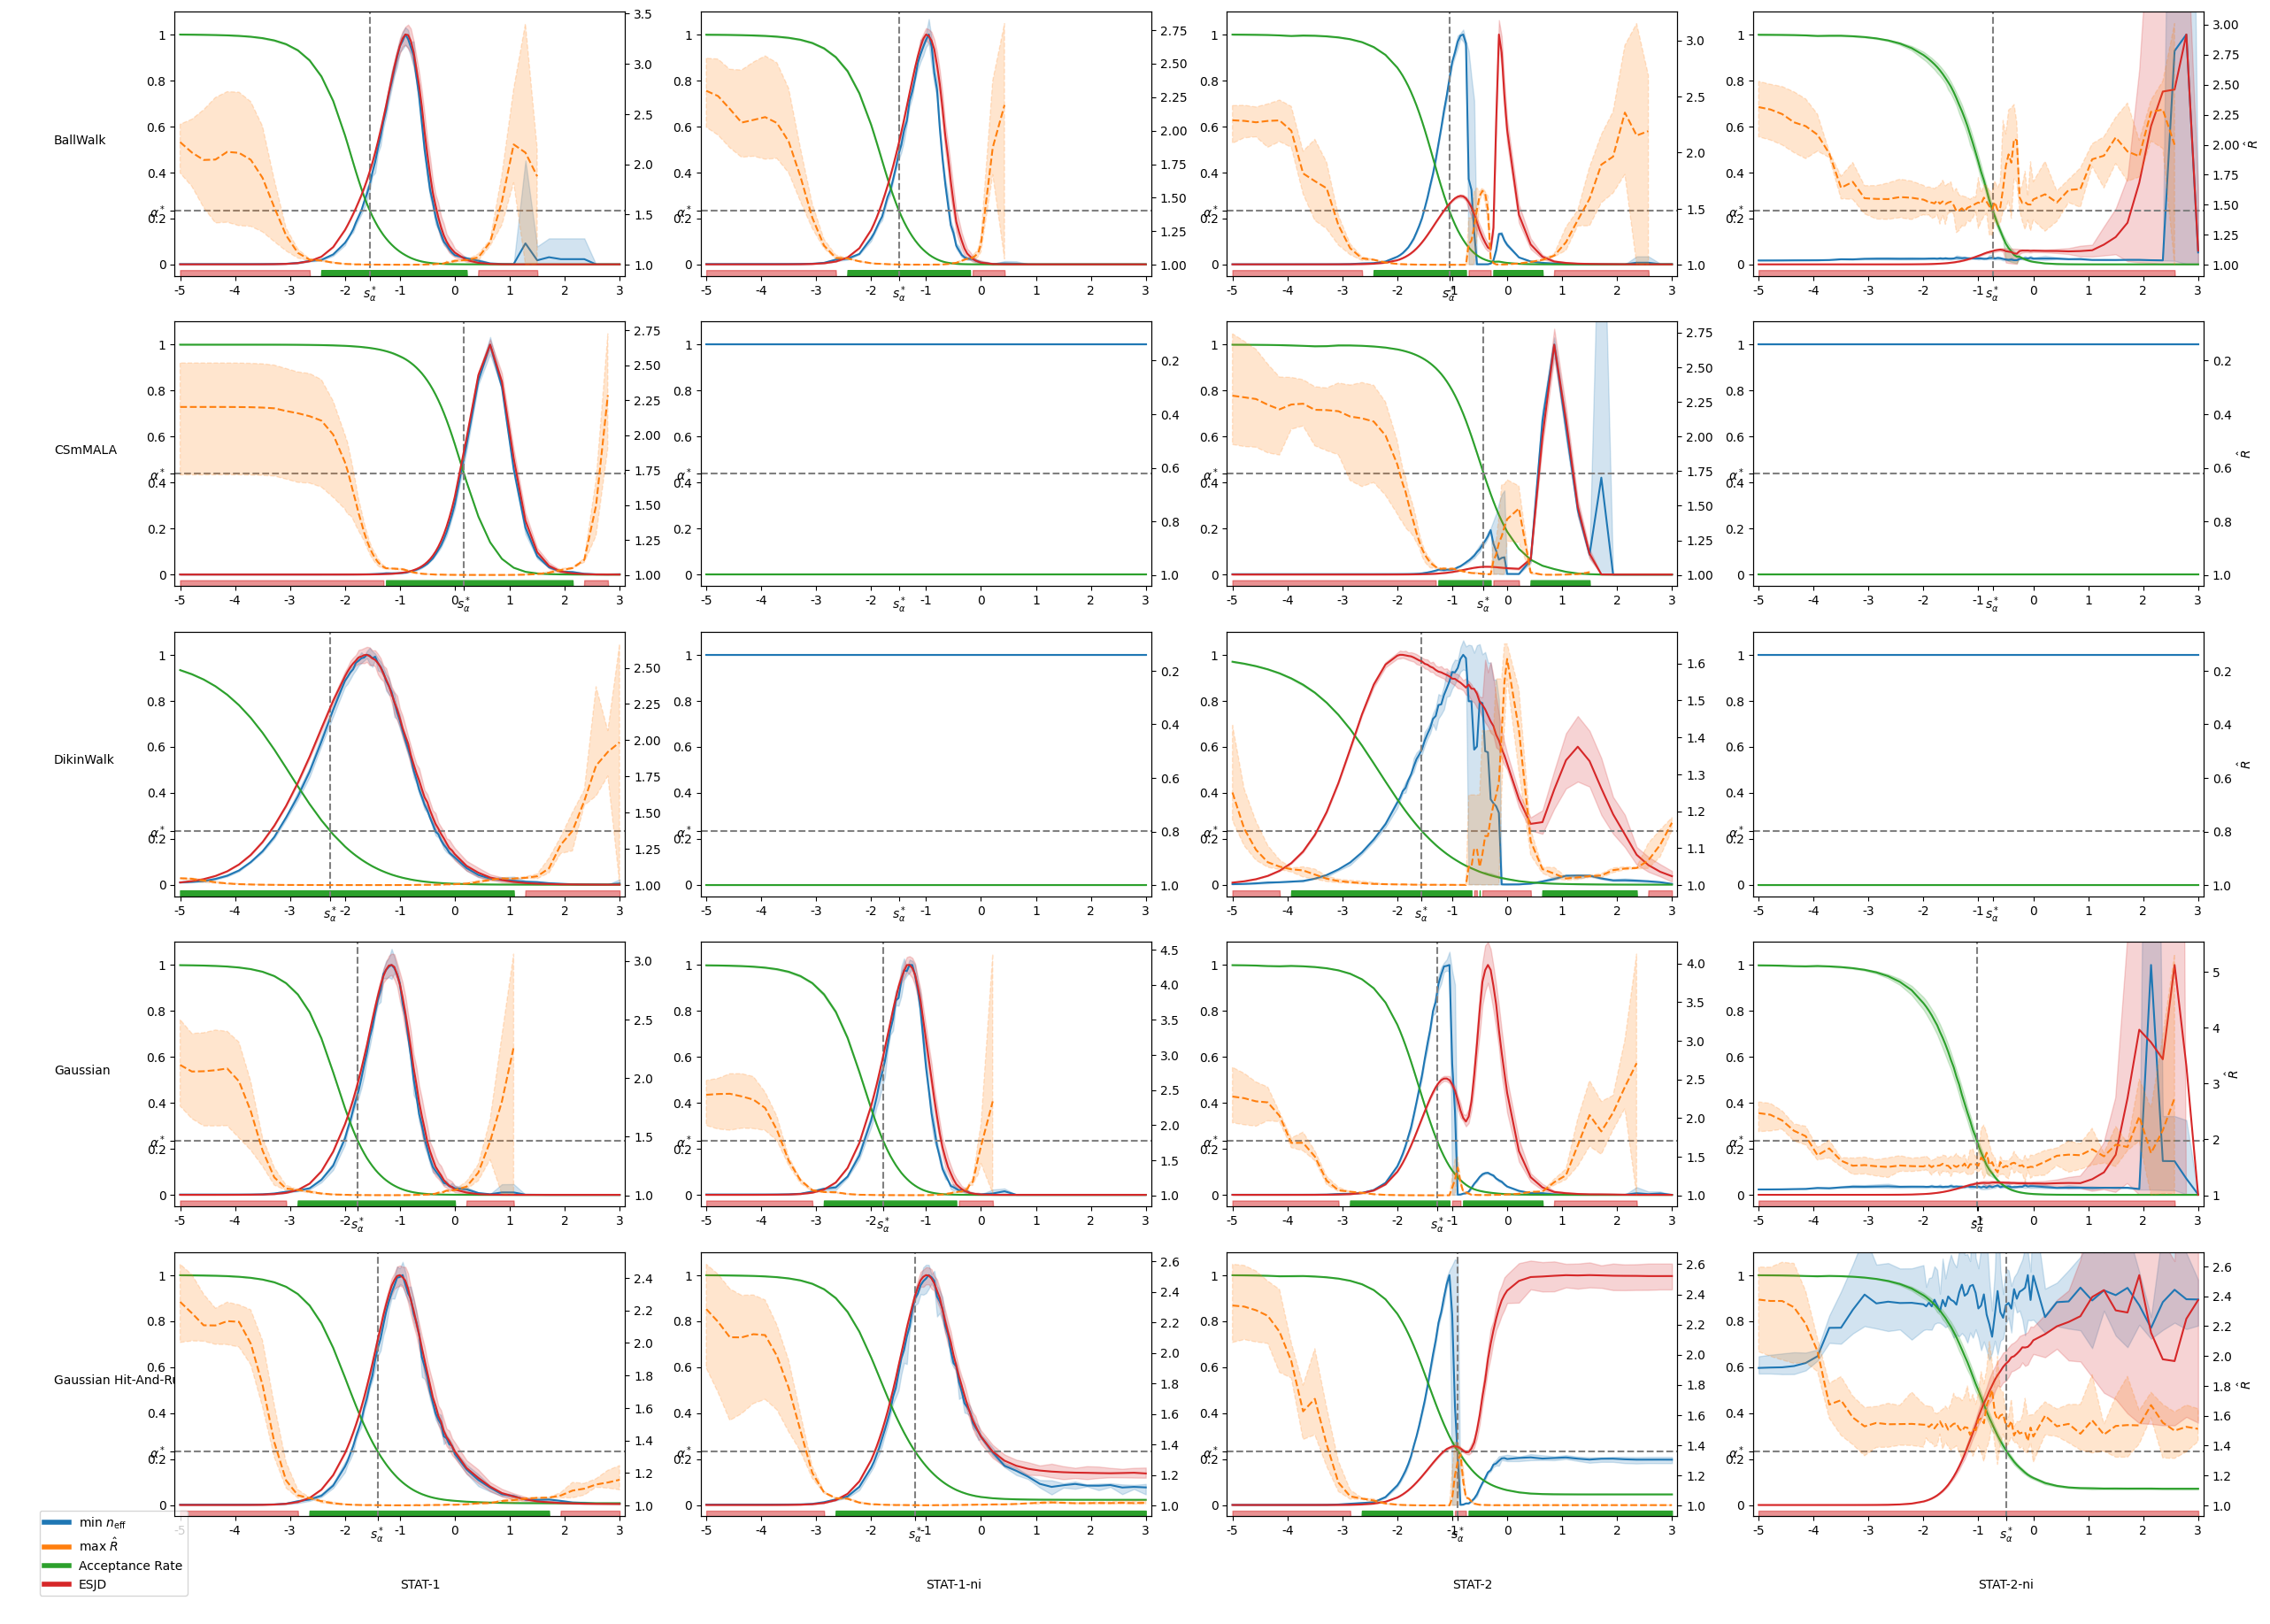

In [124]:
plt.rcParams['axes.facecolor'] = 'white'

target_style = {
    r"min $n_{\mathrm{eff}}$": {'color': 'C0'},
    r"min $n_{\mathrm{eff}}$/t": {'color': 'C0', 'linestyle': 'dashed'},
    r"max $\hat{R}$": {'color': 'C1', 'linestyle': 'dashed'},
    "Acceptance Rate": {'color': 'C2'},
    "ESJD": {'color': 'C3'},
    "ESJD/t": {'color': 'C3', 'linestyle': 'dashed'},
    "T/n": {'color': 'C4'},
}

alpha=1
gauss_opt_acc = .234
mala_opt_acc = .44

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rows, cols = len(proposals) + 1, len(problems) + 1
    fig, axs = plt.subplots(rows, cols, figsize=5*figsize, dpi=100, gridspec_kw={"height_ratios": [5]*(rows-1) + [1], "width_ratios": [1] + [5]*(cols-1)})

    fig.patch.set_facecolor('white')

    for i, problem_key in enumerate(problems):
        for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
            opt_acc = mala_opt_acc if proposal_name == 'CSmMALA' else gauss_opt_acc
            
            ax1 = axs[proposal_idx, i+1]
            ax2 = ax1.twinx()

            #rows, cols = 1, 1
            #fig, ax1 = plt.subplots(rows, cols, figsize=(16, 9), dpi=100)#, gridspec_kw={"height_ratios": [5]*(rows) + [1], "width_ratios": [1] + [5]*(cols-1)})

            a, b = np.log10(stepsize_grid[0])-.1, np.log10(stepsize_grid[-1])+.1
            
            for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
                for target_idx, target in enumerate(targets):
                    if target in [r"min $n_{\mathrm{eff}}$/t", "ESJD/t", "T/n"]: continue
                    
                    y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
                    
                    y_mean = np.mean(y, axis=-1) 
                    
                    if target not in ["Acceptance Rate", r"max $\hat{R}$"]:
                        y /= np.max(y_mean)
                        y_mean /= np.max(y_mean)

                    y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))

                    if target == r"max $\hat{R}$":
                        ax2.plot(np.log10(stepsize_grid), y_mean, label=target, alpha=alpha, **target_style[target])
                        ax2.fill_between(np.log10(stepsize_grid), y_err[0], y_err[1], alpha=.2*alpha, **target_style[target])
                        
                        good = (y_mean <= rhat_threshold)
                        bad = (y_mean > rhat_threshold)
                        ones = np.ones(stepsize_grid.shape)
                        
                        good_upper = good * ones - 1.025
                        bad_upper = bad * ones - 1.025
                        
                        ax1.fill_between(np.log10(stepsize_grid), -1*ones, bad_upper, color='C3', zorder = -6, alpha=.5)
                        ax1.fill_between(np.log10(stepsize_grid), -1*ones, good_upper, color='C2', zorder = -5, alpha=1)
                    else:
                        ax1.plot(np.log10(stepsize_grid), y_mean, label=target, alpha=alpha, **target_style[target])
                        ax1.fill_between(np.log10(stepsize_grid), y_err[0], y_err[1], alpha=.2*alpha, **target_style[target])
                        
                    if target == "Acceptance Rate":
                        diff = y_mean - opt_acc
                        if diff[0] > 0 and diff[-1] < 0:
                            last_pos_idx = np.where(diff > 0)[-1][-1]
                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = y_mean[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = y_mean[last_pos_idx+1]

                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            x_opt_acc = (opt_acc - c) / m

                            ax1.plot([x_opt_acc, x_opt_acc], [-.1, 1.1], linestyle='dashed', color='gray')
                        ax1.plot([a, b], [opt_acc, opt_acc], linestyle='dashed', color='gray')
                            
            ax1.set_yticks([0, opt_acc, .2, .4, .6, .8, 1], [0, r"$\alpha^*$", .2, .4, .6, .8, 1])
            ax1.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, x_opt_acc], [-5, -4, -3, -2, -1, 0, 1, 2, 3, r"$s_{\alpha}^*$"])
            
            ylim1 = [-.05, 1.1]
            ax1.set_xlim([a, b])
            ax1.set_ylim(ylim1)
            ylim2 = list(ax2.get_ylim())
            p = np.abs(ylim1[0]) / (ylim1[1] - ylim1[0])
            ylim2[0] = 1 - p*(ylim2[1] - 1)
            ax2.set_ylim(ylim2)
            
            #ax1.set_ylabel('normalized statistic')
            if i+1 == len(problems):
                ax2.set_ylabel(r"$\hat{R}$")

            #ax1.legend()
            #ax2.legend()
            
    #handles, labels = axs[proposal_idx, i].get_legend_handles_labels()
    #fig.legend(handles, labels, loc=(.07, .07))
            
    for i in range(rows-1):
        axs[i, 0].axis('off')
        axs[i, 0].text(.5, .5, list(proposals)[i])

    for i in range(1, cols):
        axs[-1, i].axis('off')
        axs[-1, i].text(.5, .5, list(problems)[i-1])

    axs[rows-1, 0].axis('off')
    
    custom_lines = [Line2D([0], [0], color='C0', lw=4),
                    Line2D([0], [0], color='C1', lw=4),
                    Line2D([0], [0], color='C2', lw=4),
                    Line2D([0], [0], color='C3', lw=4),
                   ]

    axs[rows-2, 1].legend(custom_lines, [r"min $n_{\mathrm{eff}}$", r"max $\hat{R}$", "Acceptance Rate", "ESJD",], loc=(-.35, -.3))
    
    plt.show()


In [53]:
def kernel(x, y, l = 1, sigma = 1):
    sqdist = np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)

def aggregate_errors(x, x_obs, y_obs, sigma_obs):
    sigma_x = np.mean(sigma_obs)**2 * np.ones(x.shape)
    for i, _ in enumerate(x):
        mean = 0
        count = 0
        for j, _ in enumerate(x_obs):
            if x[i] == x_obs[j]:
                count += 1
                mean += y_obs[j]
                sigma_x[i] += sigma_obs[j]**2 + y_obs[j]**2
        
        if count > 0:
            mean /= count
            sigma_x[i] /= count
            sigma_x[i] -= mean**2
            
    return sigma_x.reshape(-1, 1)
        
    
    
def posterior(x, x_obs, y_obs, l = 1, sigma_f = 1, sigma_y = 0, prior_mu = 0):
#    if (0 not in x_obs.shape):
    K = kernel(x_obs, x_obs, l, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = kernel(x_obs, x, l, sigma_f)
    K_ss = kernel(x, x, l, sigma_f)
    K_inv = np.linalg.inv(K)

    #sigma_x = aggregate_errors(x, x_obs, y_obs, sigma_y)

    mu = prior_mu + K_s.T.dot(K_inv).dot(y_obs - prior_mu)
    cov = K_ss - K_s.T.dot(K_inv).dot(K_s) #+ sigma_y * np.eye(len(x))

    return mu, cov
#    else:
#        return np.ones(x.shape), np.eye(len(x))


KeyboardInterrupt: 

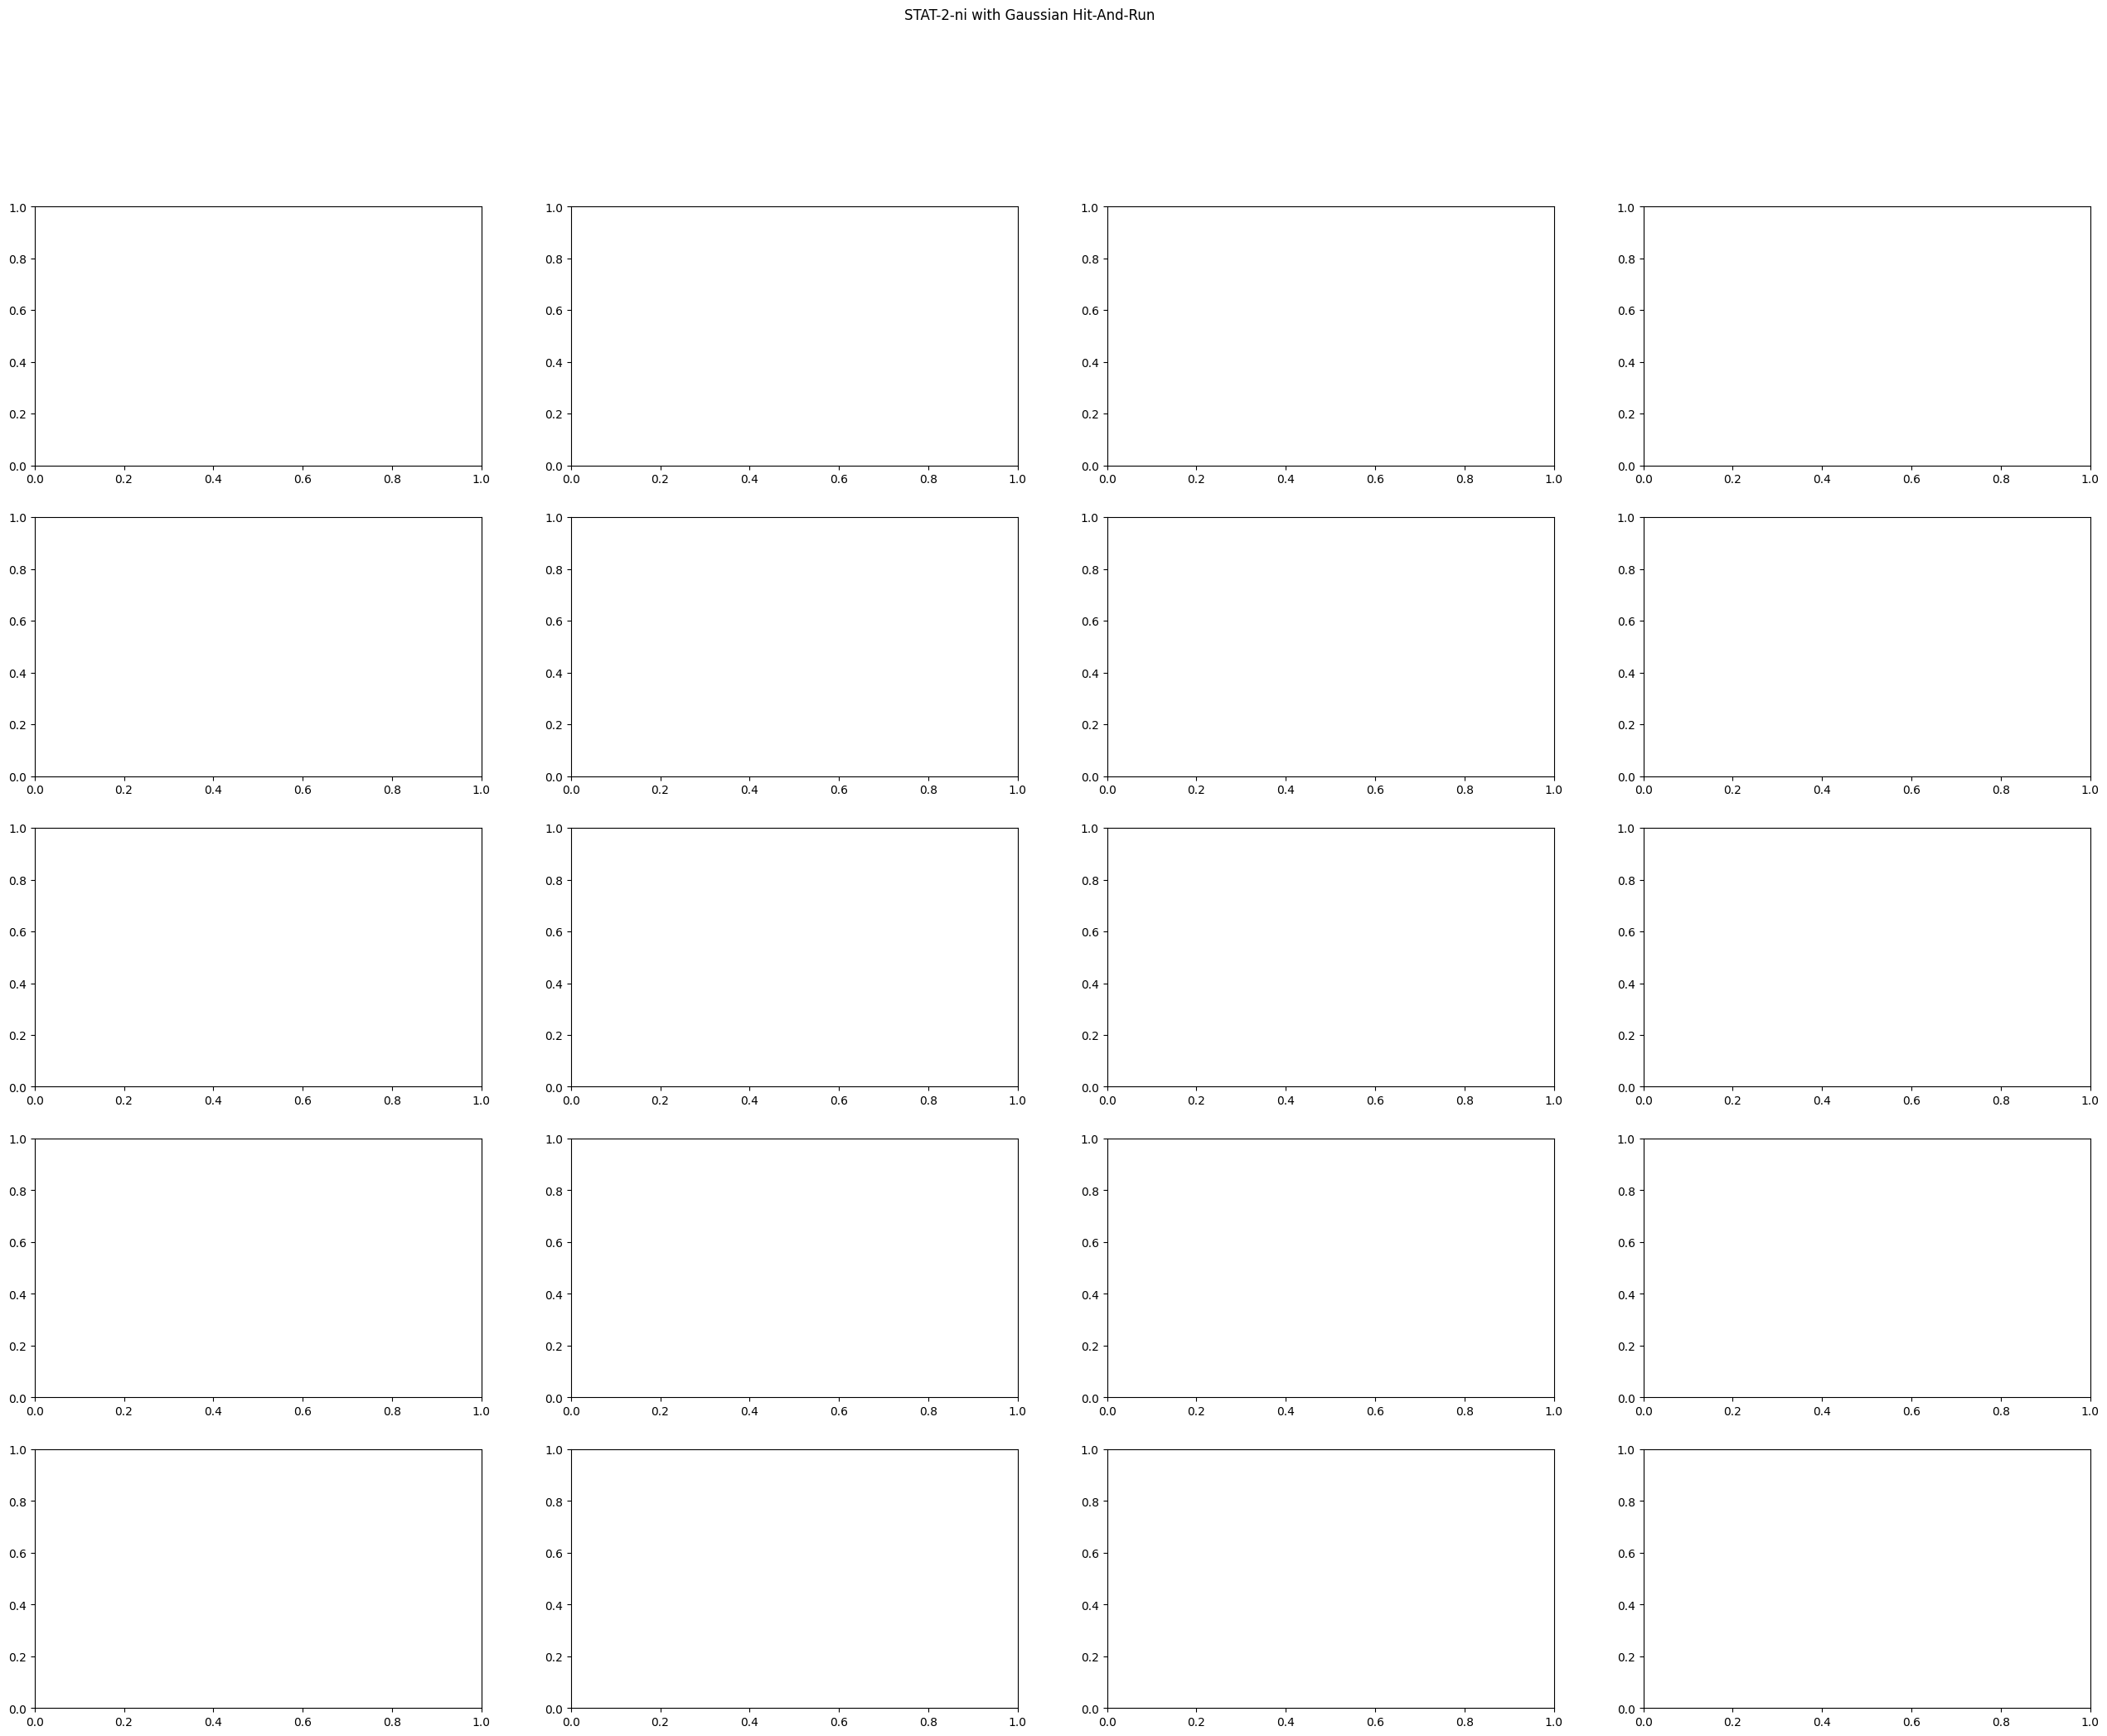

In [102]:
plt.rcParams['axes.facecolor'] = 'white'

target_style = {
    r"min $n_{\mathrm{eff}}$": {'color': 'C0'},
    r"min $n_{\mathrm{eff}}$/t": {'color': 'C0', 'linestyle': 'dashed'},
    r"max $\hat{R}$": {'color': 'C1', 'linestyle': 'dashed'},
    "Acceptance Rate": {'color': 'C2'},
    "ESJD": {'color': 'C3'},
    "ESJD/t": {'color': 'C3', 'linestyle': 'dashed'},
    "T/n": {'color': 'C4'},
}

alpha=1
gauss_opt_acc = .234
mala_opt_acc = .44

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rows, cols = len(proposals), len(problems)
    fig, axs = plt.subplots(rows, cols, figsize=5*figsize, dpi=100)#, gridspec_kw={"height_ratios": [5]*(rows) + [1], "width_ratios": [1] + [5]*(cols-1)})

    fig.suptitle(problem_key + " with " + proposal_name)

    fig.patch.set_facecolor('white')

    for i, problem_key in enumerate(problems):
        for proposal_idx, (proposal_name, proposal) in enumerate(proposals.items()):
            ax1 = axs[proposal_idx, i]
            opt_acc = mala_opt_acc if proposal_name == 'CSmMALA' else gauss_opt_acc
            
            a, b = np.log10(stepsize_grid[0])-.1, np.log10(stepsize_grid[-1])+.1
            
            for problem_idx, (dim, _, _) in enumerate(problems[problem_key]):
                for target_idx, target in enumerate(targets):
                    if target in ["Acceptance Rate", r"max $\hat{R}$", r"min $n_{\mathrm{eff}}$/t", r"min $n_{\mathrm{eff}}$", "ESJD/t", "ESJD"]: continue
                    
                    y = results[problem_key][proposal_idx, problem_idx, target_idx].reshape(len(stepsize_grid), -1)
                    
                    y_mean = np.mean(y, axis=-1) 
                    
                    if target not in ["Acceptance Rate", r"max $\hat{R}$"]:
                        y /= np.max(y_mean)
                        y_mean /= np.max(y_mean)

                    y_err = (np.quantile(y, 0.05, axis=-1), np.quantile(y, 0.95, axis=-1))

                    X, Y = np.array([np.log10(stepsize_grid)]*y.shape[-1]).T.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)
                    _x = np.linspace(-5, 3, 200).reshape(-1, 1)
                    mu, cov = posterior(_x, X, Y, sigma_y=.1, l=2)
                    
                    mu = mu.reshape(-1)
                    _x  = _x.reshape(-1)
                    
                    ax1.scatter(X, Y, s=3, alpha=.2, color='C0')
                    ax1.plot(_x, mu, color='C0')
                    ax1.fill_between(_x, mu - np.sqrt(np.diag(cov)), mu + np.sqrt(np.diag(cov)), alpha=.5, color='C0')
                        
                    if target == "Acceptance Rate":
                        diff = y_mean - opt_acc
                        if diff[0] > 0 and diff[-1] < 0:
                            last_pos_idx = np.where(diff > 0)[-1][-1]
                            x1 = np.log10(stepsize_grid)[last_pos_idx]
                            y1 = y_mean[last_pos_idx]
                            x2 = np.log10(stepsize_grid)[last_pos_idx+1]
                            y2 = y_mean[last_pos_idx+1]

                            m = (y2 - y1) / (x2 - x1)
                            c = y1 - m * x1

                            x_opt_acc = (opt_acc - c) / m

                            ax1.plot([x_opt_acc, x_opt_acc], [-.1, 1.1], linestyle='dashed', color='gray')
                            ax1.plot([a, b], [opt_acc, opt_acc], linestyle='dashed', color='gray')
                            
            ax1.set_yticks([0, opt_acc, .2, .4, .6, .8, 1], [0, r"$\alpha^*$", .2, .4, .6, .8, 1])
            ax1.set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, x_opt_acc], [-5, -4, -3, -2, -1, 0, 1, 2, 3, r"$s_{\alpha}^*$"])
            
            ylim1 = [-.05, 1.1]
            ax1.set_xlim([a, b])
            ax1.set_ylim(ylim1)
            
            #ax1.set_ylabel('normalized statistic')
            
            #ax1.legend()
            
            #fig.savefig(session+"_"+problem_key+"_"+proposal_name+".png")
    plt.show()


1
2
3
4


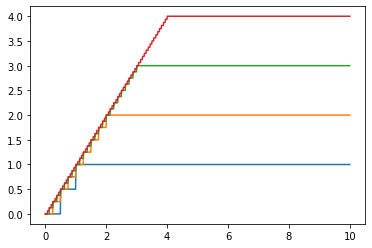

In [39]:
d = lambda x, n: (x <= n) * np.floor(x * 2**n) / 2**n + (x > n) * n
x = np.linspace(0, 10, 1000)
for n in range(1, 5):
    print(n)
    plt.plot(x, d(x, n))

In [33]:
(x > n) * n

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])